In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

def load_optimization_data(base_path, method_name, num_trials=5):
    """
    Load optimization data from JSON files.
    
    Args:
        base_path: Base directory path
        method_name: Either 'bayesian' or 'edm_cosine_warm_restarts'
        num_trials: Number of trials to load
    
    Returns:
        Dictionary with trial data
    """
    data = {}
    
    for trial in range(1, num_trials + 1):
        if method_name == 'bayesian':
            file_path = f"{base_path}/bayesian_trial_{trial}/progress/Bayesian_Optimization_trial_{trial}_progress.json"
        else:  # edm_cosine_warm_restarts
            file_path = f"{base_path}/edm_cosine_annealing_trial_{trial}/progress/EDM_Cosine_Annealing_trial_{trial}_progress.json"
        
        try:
            with open(file_path, 'r') as f:
                trial_data = json.load(f)
                
                # Normalize the data structure to handle differences between methods
                normalized_data = normalize_trial_data(trial_data, method_name)
                data[f'trial_{trial}'] = normalized_data
                print(f"Loaded {method_name} trial {trial}")
                
        except FileNotFoundError:
            print(f"Warning: Could not find {file_path}")
        except json.JSONDecodeError:
            print(f"Warning: Could not parse JSON in {file_path}")
    
    return data

def normalize_trial_data(trial_data, method_name):
    """
    Normalize trial data to have consistent structure between methods.
    
    Args:
        trial_data: Raw trial data from JSON
        method_name: Either 'bayesian' or 'edm_cosine_warm_restarts'
    
    Returns:
        Normalized trial data dictionary
    """
    normalized = trial_data.copy()
    
    # Ensure we have consistent iteration numbering
    if method_name == 'bayesian':
        # Bayesian uses 'evaluations' field
        normalized['iterations'] = trial_data.get('evaluations', [])
    else:
        # EDM uses 'steps' field
        normalized['iterations'] = trial_data.get('steps', [])
    
    # Ensure we have the required fields
    if 'weighted_sums' not in normalized:
        print(f"Warning: No 'weighted_sums' field found in {method_name} data")
        normalized['weighted_sums'] = []
    
    if 'best_so_far' not in normalized:
        print(f"Warning: No 'best_so_far' field found in {method_name} data")
        normalized['best_so_far'] = []
    
    return normalized

def plot_convergence(bayesian_data, edm_data, save_path=None):
    """
    Plot convergence curves for both optimization methods.
    
    Args:
        bayesian_data: Dictionary with Bayesian optimization trial data
        edm_data: Dictionary with EDM optimization trial data
        save_path: Optional path to save the plot
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different trials
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot Bayesian Optimization
    ax1.set_title('Bayesian Optimization Convergence', fontsize=14, fontweight='bold')
    if bayesian_data:
        for i, (trial_name, trial_data) in enumerate(bayesian_data.items()):
            iterations = trial_data['iterations']
            best_so_far = trial_data['best_so_far']
            if iterations and best_so_far:
                ax1.plot(iterations, best_so_far, 
                        color=colors[i % len(colors)], 
                        linewidth=2, 
                        label=f'Trial {i+1}',
                        marker='o', 
                        markersize=3,
                        alpha=0.8)
        
        ax1.set_xlabel('Evaluation Number', fontsize=12)
        ax1.set_ylabel('Best Weighted Sum So Far', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(left=0)
    else:
        ax1.text(0.5, 0.5, 'No Bayesian data available', 
                ha='center', va='center', transform=ax1.transAxes)
    
    # Plot EDM Gradient
    ax2.set_title('EDM Gradient Convergence', fontsize=14, fontweight='bold')
    if edm_data:
        for i, (trial_name, trial_data) in enumerate(edm_data.items()):
            iterations = trial_data['iterations']
            best_so_far = trial_data['best_so_far']
            if iterations and best_so_far:
                ax2.plot(iterations, best_so_far, 
                        color=colors[i % len(colors)], 
                        linewidth=2, 
                        label=f'Trial {i+1}',
                        marker='s', 
                        markersize=3,
                        alpha=0.8)
        
        ax2.set_xlabel('Step Number', fontsize=12)
        ax2.set_ylabel('Best Weighted Sum So Far', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(left=0)
    else:
        ax2.text(0.5, 0.5, 'No EDM data available', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

def plot_comparison_overlay(bayesian_data, edm_data, save_path=None):
    """
    Create an overlay plot comparing both methods.
    
    Args:
        bayesian_data: Dictionary with Bayesian optimization trial data
        edm_data: Dictionary with EDM optimization trial data
        save_path: Optional path to save the plot
    """
    plt.figure(figsize=(12, 8))
    
    # Plot Bayesian trials
    if bayesian_data:
        for i, (trial_name, trial_data) in enumerate(bayesian_data.items()):
            iterations = trial_data['iterations']
            best_so_far = trial_data['best_so_far']
            if iterations and best_so_far:
                plt.plot(iterations, best_so_far, 
                        color='blue', 
                        alpha=0.6,
                        linewidth=1.5,
                        label='Bayesian Optimization' if i == 0 else "")
    
    # Plot EDM trials
    if edm_data:
        for i, (trial_name, trial_data) in enumerate(edm_data.items()):
            iterations = trial_data['iterations']
            best_so_far = trial_data['best_so_far']
            if iterations and best_so_far:
                plt.plot(iterations, best_so_far, 
                        color='red', 
                        alpha=0.6,
                        linewidth=1.5,
                        label='EDM Gradient' if i == 0 else "")
    
    # Calculate and plot averages
    if bayesian_data:
        max_iterations = max(len(trial_data['iterations']) for trial_data in bayesian_data.values() if trial_data['iterations'])
        avg_bayesian = []
        for iter_idx in range(max_iterations):
            values = []
            for trial_data in bayesian_data.values():
                if iter_idx < len(trial_data['best_so_far']):
                    values.append(trial_data['best_so_far'][iter_idx])
            if values:
                avg_bayesian.append(np.mean(values))
        
        if avg_bayesian:
            plt.plot(range(len(avg_bayesian)), avg_bayesian, 
                    color='blue', linewidth=3, 
                    label='Bayesian Avg', linestyle='--')
    
    if edm_data:
        max_iterations = max(len(trial_data['iterations']) for trial_data in edm_data.values() if trial_data['iterations'])
        avg_edm = []
        for iter_idx in range(max_iterations):
            values = []
            for trial_data in edm_data.values():
                if iter_idx < len(trial_data['best_so_far']):
                    values.append(trial_data['best_so_far'][iter_idx])
            if values:
                avg_edm.append(np.mean(values))
        
        if avg_edm:
            plt.plot(range(len(avg_edm)), avg_edm, 
                    color='red', linewidth=3, 
                    label='EDM Avg', linestyle='--')
    
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('Best Weighted Sum So Far', fontsize=12)
    plt.title('Optimization Methods Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim(left=0)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to {save_path}")
    
    plt.show()

def plot_weighted_sums_progression(bayesian_data, edm_data, save_path=None):
    """
    Plot the raw weighted sums (not cumulative best) to show the actual progression.
    
    Args:
        bayesian_data: Dictionary with Bayesian optimization trial data
        edm_data: Dictionary with EDM optimization trial data
        save_path: Optional path to save the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different trials
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot Bayesian Optimization raw weighted sums
    ax1.set_title('Bayesian Optimization - Raw Weighted Sums', fontsize=14, fontweight='bold')
    if bayesian_data:
        for i, (trial_name, trial_data) in enumerate(bayesian_data.items()):
            iterations = trial_data['iterations']
            weighted_sums = trial_data['weighted_sums']
            if iterations and weighted_sums:
                ax1.plot(iterations, weighted_sums, 
                        color=colors[i % len(colors)], 
                        linewidth=1.5, 
                        label=f'Trial {i+1}',
                        alpha=0.7)
        
        ax1.set_xlabel('Evaluation Number', fontsize=12)
        ax1.set_ylabel('Weighted Sum', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(left=0)
    
    # Plot EDM raw weighted sums
    ax2.set_title('EDM Gradient - Raw Weighted Sums', fontsize=14, fontweight='bold')
    if edm_data:
        for i, (trial_name, trial_data) in enumerate(edm_data.items()):
            iterations = trial_data['iterations']
            weighted_sums = trial_data['weighted_sums']
            if iterations and weighted_sums:
                ax2.plot(iterations, weighted_sums, 
                        color=colors[i % len(colors)], 
                        linewidth=1.5, 
                        label=f'Trial {i+1}',
                        alpha=0.7)
        
        ax2.set_xlabel('Step Number', fontsize=12)
        ax2.set_ylabel('Weighted Sum', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(left=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Raw weighted sums plot saved to {save_path}")
    
    plt.show()

Loading Bayesian Optimization data...
Loaded bayesian trial 1
Loaded bayesian trial 2
Loaded bayesian trial 3
Loaded bayesian trial 4
Loaded bayesian trial 5
Loading EDM Gradient data...
Loaded edm_cosine_annealing trial 1
Loaded edm_cosine_annealing trial 2
Loaded edm_cosine_annealing trial 3
Loaded edm_cosine_annealing trial 4
Loaded edm_cosine_annealing trial 5
Creating convergence plots...
Plot saved to convergence_comparison.png


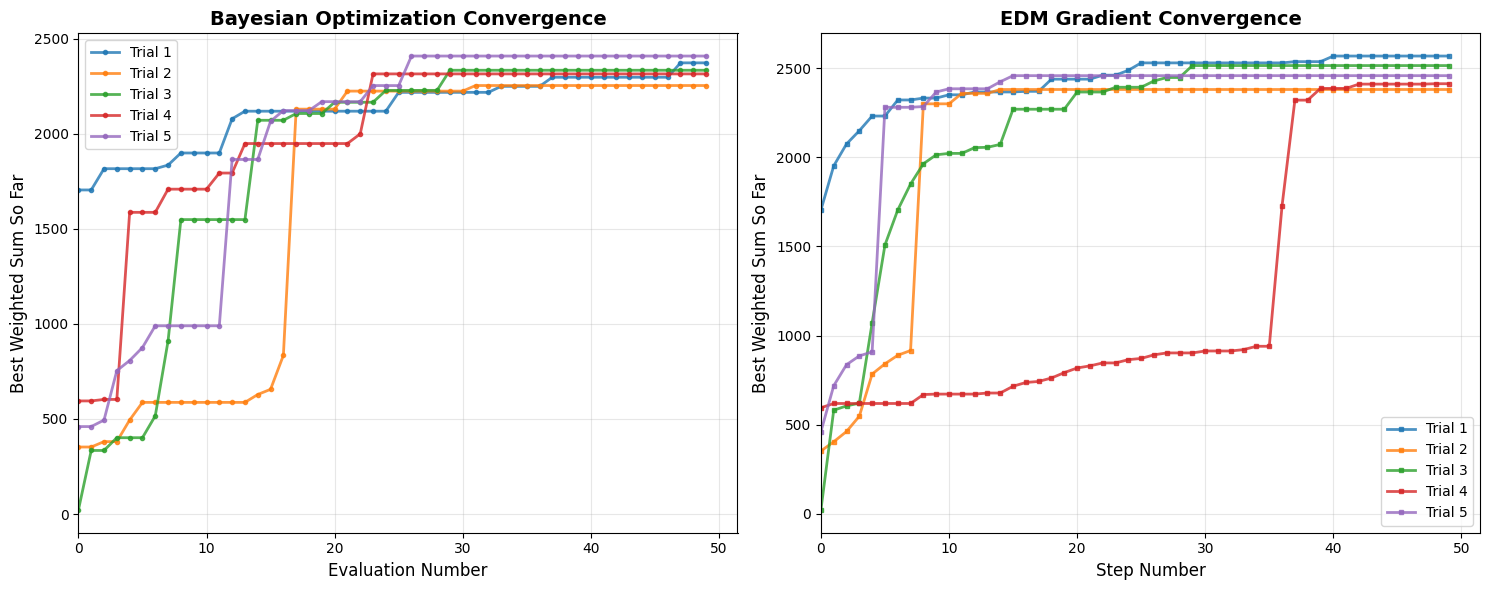

Creating overlay comparison plot...
Comparison plot saved to methods_comparison.png


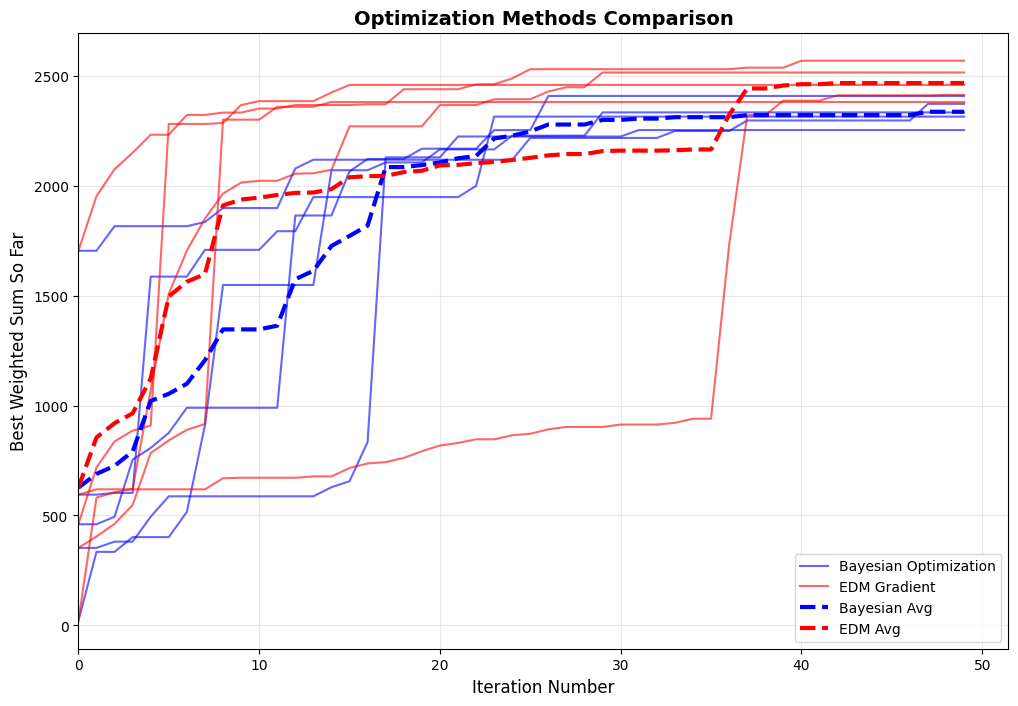

In [16]:
# Set the base path to your results directory
# Adjust this path according to your file structure
base_path = "cosine_annealing_vs_bayesian_results"

# Load data for both methods
print("Loading Bayesian Optimization data...")
bayesian_data = load_optimization_data(base_path, 'bayesian', num_trials=5)

print("Loading EDM Gradient data...")
edm_data = load_optimization_data(base_path, 'edm_cosine_annealing', num_trials=5)

# Create plots
if bayesian_data or edm_data:
    print("Creating convergence plots...")
    plot_convergence(bayesian_data, edm_data, save_path='convergence_comparison.png')
    
    print("Creating overlay comparison plot...")
    plot_comparison_overlay(bayesian_data, edm_data, save_path='methods_comparison.png')
else:
    print("No data loaded. Please check your file paths.")

Win-Loss Record (out of 5 trials):
  Bayesian Optimization: 0 wins (0.0%)
  EDM Cosine Warm Restarts: 5 wins (100.0%)
  Ties: 0 (0.0%)


Trial-by-Trial Comparison:
  Trial 1: EDM wins (Bayesian: 2372.5984, EDM: 2568.7852, Diff: -196.1868)
  Trial 2: EDM wins (Bayesian: 2253.4033, EDM: 2380.9646, Diff: -127.5613)
  Trial 3: EDM wins (Bayesian: 2333.7363, EDM: 2515.2754, Diff: -181.5391)
  Trial 4: EDM wins (Bayesian: 2314.5281, EDM: 2413.3958, Diff: -98.8677)
  Trial 5: EDM wins (Bayesian: 2408.4905, EDM: 2458.6777, Diff: -50.1873)


Final Value Statistics:
  Bayesian - Mean: 2336.5513, Std: 52.6900
  EDM - Mean: 2467.4197, Std: 67.8743


Best Overall Value Statistics:
  Bayesian - Mean: 2336.5513, Std: 52.6900
  EDM - Mean: 2467.4197, Std: 67.8743


Statistical Tests:
  Paired t-test: t = -4.8808, p = 0.0082
    → EDM significantly better (p < 0.05)
  Wilcoxon signed-rank test: W = 0.0000, p = 0.0625
  Effect size (Cohen's d): -2.1539
    → large effect size


## CFG analysis

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import sys
import os

# Add project root to path
sys.path.append('.')

from src.modules_1d import EDMPrecond
from src.diffusion import EdmSampler
from optimize_conditional import create_energy_axis
from scipy import stats

# Configure matplotlib for better readability
basesize = 36
plt.rcParams.update({
    'font.size': basesize,           # Base font size
    'font.weight': 'bold',     # Make text bold
    'axes.titlesize': basesize-6,      # Title font size
    'axes.labelsize': basesize-8,      # Axis label font size
    'xtick.labelsize': basesize-10,     # X-tick label size
    'ytick.labelsize': basesize-10,     # Y-tick label size
    'legend.fontsize': basesize-10,     # Legend font size
    'figure.titlesize': basesize-4,    # Figure title size
    'lines.linewidth': 3,      # Thicker lines
    'grid.linewidth': 1.5,     # Thicker grid lines
    'axes.linewidth': 2,       # Thicker axes
    'xtick.major.width': 2,    # Thicker tick marks
    'ytick.major.width': 2,    # Thicker tick marks
})

class ExclusionEvaluator:
    def __init__(self, model_dir='models', data_dir='data/spectra', params_file='data/params.csv', 
                 device=None, resolution=256):
        self.model_dir = Path(model_dir)
        self.data_dir = Path(data_dir)
        self.params_file = params_file
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.resolution = resolution
        self.settings_dim = 3
        
        print(f"Using device: {self.device}")
    
    def load_model(self, excluded_experiment):
        """Load exclusion model for a specific experiment."""
        # Find model directory
        model_name = f"edm_4kepochs_exclude_{excluded_experiment}"
        model_path = self.model_dir / model_name
        
        if not model_path.exists():
            raise FileNotFoundError(f"Model not found: {model_path}")
        
        # Initialize model
        model = EDMPrecond(
            resolution=self.resolution,
            settings_dim=self.settings_dim,
            sigma_min=0,
            sigma_max=float('inf'),
            sigma_data=0.112,
            model_type='UNet_conditional',
            device=self.device
        ).to(self.device)
        
        # Find checkpoint
        checkpoint_files = ['ema_ckpt_final.pt', 'ema_ckpt.pt']
        checkpoint_path = None
        
        for checkpoint_file in checkpoint_files:
            potential_path = model_path / checkpoint_file
            if potential_path.exists():
                checkpoint_path = potential_path
                break
        
        if checkpoint_path is None:
            raise FileNotFoundError(f"No checkpoint found in {model_path}")
        
        print(f"Loading: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        model.load_state_dict(checkpoint)
        model.eval()
        
        return model
    
    def get_experiment_settings(self, experiment_num):
        """Get experimental settings for an experiment."""
        params_df = pd.read_csv(self.params_file)
        exp_row = params_df[params_df['experiment'] == experiment_num]
        
        if exp_row.empty:
            raise ValueError(f"Experiment {experiment_num} not found in {self.params_file}")
        
        settings = [
            float(exp_row.iloc[0]['E']),
            float(exp_row.iloc[0]['P']), 
            float(exp_row.iloc[0]['ms'])
        ]
        
        return settings
    
    def load_original_spectra(self, experiment_num):
        """Load original spectra for an experiment."""
        exp_dir = self.data_dir / str(experiment_num)
        csv_files = list(exp_dir.glob("*.csv"))
        
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in {exp_dir}")
        
        spectra = []
        for csv_file in csv_files:
            df = pd.read_csv(csv_file)
            if 'intensity' in df.columns:
                spectra.append(df['intensity'].values)
        
        return np.array(spectra)
    
    def generate_spectra(self, model, experiment_settings, n_samples, cfg_scale=3.0, num_steps=30):
        """Generate spectra using the model."""
        sampler = EdmSampler(net=model, num_steps=num_steps)
        
        with torch.no_grad():
            settings_tensor = torch.tensor(experiment_settings, dtype=torch.float32).reshape(1, -1).to(self.device)
            
            samples = sampler.sample(
                resolution=self.resolution,
                device=self.device,
                settings=settings_tensor,
                n_samples=n_samples,
                cfg_scale=cfg_scale,
                settings_dim=self.settings_dim,
                smooth_output=False,
                smooth_kernel_size=5,
                smooth_sigma=2.0
            )
            
            samples_np = samples.cpu().numpy()
            if samples_np.ndim == 3:
                samples_np = samples_np[:, 0, :]
            
            return samples_np
    
    def calculate_wasserstein_distance(self, original_spectra, generated_spectra):
        """Calculate average Wasserstein distance across spectrum bins."""
        # Truncate original to match model resolution
        if original_spectra.shape[1] > self.resolution:
            original_truncated = original_spectra[:, :self.resolution]
        else:
            original_truncated = original_spectra
        
        distances = []
        for bin_idx in range(self.resolution):
            orig_bin = original_truncated[:, bin_idx]
            gen_bin = generated_spectra[:, bin_idx]
            
            # Skip bins with very low intensity
            if np.mean(orig_bin) < 0.01 and np.mean(gen_bin) < 0.01:
                continue
                
            try:
                dist = stats.wasserstein_distance(orig_bin, gen_bin)
                distances.append(dist)
            except:
                continue
        
        return np.mean(distances) if distances else float('nan')
    
    def plot_comparison(self, original_spectra, generated_spectra, experiment_num, 
                       experiment_settings, cfg_scale, num_steps, figsize=(18, 12)):
        """Plot comparison between original and generated spectra."""
        # Truncate original to match model resolution
        if original_spectra.shape[1] > self.resolution:
            original_truncated = original_spectra[:, :self.resolution]
        else:
            original_truncated = original_spectra
        
        energy_axis = create_energy_axis(self.resolution)
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Average spectra comparison
        axes[0,0].plot(energy_axis, np.mean(original_truncated, axis=0), 'b-', 
                      label='Original (avg)', linewidth=4, alpha=0.8)
        axes[0,0].plot(energy_axis, np.mean(generated_spectra, axis=0), 'r--', 
                      label='Generated (avg)', linewidth=4, alpha=0.8)
        axes[0,0].set_xlabel('Energy (MeV)', fontsize=20, fontweight='bold')
        axes[0,0].set_ylabel('Intensity', fontsize=20, fontweight='bold')
        axes[0,0].set_title('Average Spectra Comparison', fontsize=22, fontweight='bold', pad=20)
        axes[0,0].legend(fontsize=18, frameon=True, fancybox=True, shadow=True)
        axes[0,0].grid(True, alpha=0.4, linewidth=1.5)
        
        # Individual samples
        n_show = min(5, len(original_truncated), len(generated_spectra))
        for i in range(n_show):
            axes[0,1].plot(energy_axis, original_truncated[i], 'b-', alpha=0.7, linewidth=2.5)
            axes[0,1].plot(energy_axis, generated_spectra[i], 'r--', alpha=0.7, linewidth=2.5)
        axes[0,1].set_xlabel('Energy (MeV)', fontsize=20, fontweight='bold')
        axes[0,1].set_ylabel('Intensity', fontsize=20, fontweight='bold')
        axes[0,1].set_title(f'Sample Spectra (first {n_show})', fontsize=22, fontweight='bold', pad=20)
        axes[0,1].grid(True, alpha=0.4, linewidth=1.5)
        
        # Intensity distributions
        orig_flat = original_truncated.flatten()
        gen_flat = generated_spectra.flatten()
        axes[1,0].hist(orig_flat, bins=50, alpha=0.7, label='Original', density=True, color='blue', edgecolor='black', linewidth=1.5)
        axes[1,0].hist(gen_flat, bins=50, alpha=0.7, label='Generated', density=True, color='red', edgecolor='black', linewidth=1.5)
        axes[1,0].set_xlabel('Intensity', fontsize=20, fontweight='bold')
        axes[1,0].set_ylabel('Density', fontsize=20, fontweight='bold')
        axes[1,0].set_title('Intensity Distribution', fontsize=18, fontweight='bold', pad=20)
        axes[1,0].legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
        axes[1,0].grid(True, alpha=0.4, linewidth=1.5)
        
        # Standard deviation comparison
        axes[1,1].plot(energy_axis, np.std(original_truncated, axis=0), 'b-', 
                      label='Original std', linewidth=4, alpha=0.8)
        axes[1,1].plot(energy_axis, np.std(generated_spectra, axis=0), 'r--', 
                      label='Generated std', linewidth=4, alpha=0.8)
        axes[1,1].set_xlabel('Energy (MeV)', fontsize=16, fontweight='bold')
        axes[1,1].set_ylabel('Standard Deviation', fontsize=16, fontweight='bold')
        axes[1,1].set_title('Spectral Variability', fontsize=18, fontweight='bold', pad=20)
        axes[1,1].legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
        axes[1,1].grid(True, alpha=0.4, linewidth=1.5)
        
        # Calculate Wasserstein distance for title
        wasserstein_dist = self.calculate_wasserstein_distance(original_spectra, generated_spectra)
        
        plt.suptitle(f'Experiment {experiment_num} | E={experiment_settings[0]}, P={experiment_settings[1]}, ms={experiment_settings[2]}\n'
                    f'CFG={cfg_scale}, Steps={num_steps} | Wasserstein Distance: {wasserstein_dist:.4f}', 
                    fontsize=20, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.02, 1, 0.95])
        plt.show()
        
        return wasserstein_dist

    def plot_mean_spectrum_comparison(self, original_spectra, generated_spectra, experiment_num, 
                                    experiment_settings, cfg_scale, num_steps, ax=None):
        """Plot only the mean spectrum comparison."""
        # Truncate original to match model resolution
        if original_spectra.shape[1] > self.resolution:
            original_truncated = original_spectra[:, :self.resolution]
        else:
            original_truncated = original_spectra
        
        energy_axis = create_energy_axis(self.resolution)
        
        # Use provided axis or create new figure
        if ax is None:
            plt.figure(figsize=(12, 8))
            plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
            ax = plt.gca()
        
        # Plot average spectra
        orig_mean = np.mean(original_truncated, axis=0)
        gen_mean = np.mean(generated_spectra, axis=0)
        
        ax.plot(energy_axis, orig_mean, 'b-', label='Original (avg)', linewidth=4, alpha=0.8)
        ax.plot(energy_axis, gen_mean, 'r--', label='Generated (avg)', linewidth=4, alpha=0.8)
        
        # Calculate Wasserstein distance
        wasserstein_dist = self.calculate_wasserstein_distance(original_spectra, generated_spectra)
        
        ax.set_xlabel('Energy (MeV)', fontsize=20, fontweight='bold')
        ax.set_ylabel('Intensity (a.u.)', fontsize=20, fontweight='bold')
        ax.set_title(f'Exp {experiment_num} | E={experiment_settings[0]}, P={experiment_settings[1]}, ms={experiment_settings[2]}\n'
                    f'CFG={cfg_scale}, Steps={num_steps} | WD: {wasserstein_dist:.4f}', 
                    fontsize=20, fontweight='bold', pad=10)
        ax.legend(fontsize=18, frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.4, linewidth=1.5)
        
        # Make tick labels bold
        ax.tick_params(axis='both', which='major', labelsize=16, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        if ax is None:
            plt.tight_layout()
            plt.show()
        
        return wasserstein_dist

def evaluate_single_experiment(excluded_experiment, cfg_scale=3.0, num_steps=30, 
                             model_dir='models', data_dir='data/spectra', params_file='data/params.csv'):
    """
    Evaluate a single exclusion experiment with specified parameters.
    
    Parameters:
    - excluded_experiment: int, experiment number that was excluded during training
    - cfg_scale: float, classifier-free guidance scale
    - num_steps: int, number of sampling steps
    - model_dir: str, directory containing trained models
    - data_dir: str, directory containing original spectra data
    - params_file: str, path to experiment parameters CSV
    
    Returns:
    - wasserstein_distance: float, calculated distance metric
    """
    
    # Initialize evaluator
    evaluator = ExclusionEvaluator(model_dir=model_dir, data_dir=data_dir, params_file=params_file)
    
    print(f"\n{'='*60}")
    print(f"{'SINGLE EXPERIMENT EVALUATION':^60}")
    print(f"{'='*60}")
    print(f"Experiment Number: {excluded_experiment}")
    print(f"CFG Scale: {cfg_scale} | Sampling Steps: {num_steps}")
    print(f"{'='*60}")
    
    # Load model
    model = evaluator.load_model(excluded_experiment)
    print(f"✓ Model loaded successfully")
    
    # Get experiment settings
    experiment_settings = evaluator.get_experiment_settings(excluded_experiment)
    print(f"✓ Experiment settings: E={experiment_settings[0]}, P={experiment_settings[1]}, ms={experiment_settings[2]}")
    
    # Load original spectra
    original_spectra = evaluator.load_original_spectra(excluded_experiment)
    n_samples = len(original_spectra)
    print(f"✓ Loaded {n_samples} original spectra")
    
    # Generate spectra
    print(f"🔄 Generating {n_samples} samples...")
    generated_spectra = evaluator.generate_spectra(
        model, experiment_settings, n_samples, cfg_scale=cfg_scale, num_steps=num_steps
    )
    print(f"✓ Generated spectra shape: {generated_spectra.shape}")
    
    # Plot comparison and calculate distance
    print(f"📊 Creating comparison plots...")
    wasserstein_distance = evaluator.plot_comparison(
        original_spectra, generated_spectra, excluded_experiment, 
        experiment_settings, cfg_scale, num_steps
    )
    
    print(f"\n{'='*60}")
    print(f"{'RESULTS':^60}")
    print(f"{'='*60}")
    print(f"Wasserstein Distance: {wasserstein_distance:.6f}")
    print(f"{'='*60}")
    
    return wasserstein_distance

def evaluate_multiple_experiments(experiments=[3, 8, 11, 19, 21], cfg_scale=3.0, num_steps=30, 
                                model_dir='models', data_dir='data/spectra', params_file='data/params.csv',
                                figsize=(24, 16)):
    """
    Evaluate multiple exclusion experiments and show mean spectrum comparisons.
    
    Parameters:
    - experiments: list of int, experiment numbers to evaluate
    - cfg_scale: float, classifier-free guidance scale
    - num_steps: int, number of sampling steps
    - model_dir: str, directory containing trained models
    - data_dir: str, directory containing original spectra data
    - params_file: str, path to experiment parameters CSV
    - figsize: tuple, figure size for the combined plot
    
    Returns:
    - results: dict, Wasserstein distances for each experiment
    """
    
    # Initialize evaluator
    evaluator = ExclusionEvaluator(model_dir=model_dir, data_dir=data_dir, params_file=params_file)
    
    print(f"Evaluating experiments: {experiments}")
    print(f"Parameters: CFG scale = {cfg_scale}, Sampling steps = {num_steps}")
    
    # Create subplots
    n_experiments = len(experiments)
    cols = 2
    rows = (n_experiments + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_experiments == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    results = {}
    
    for i, experiment_num in enumerate(experiments):
        print(f"\nEvaluating experiment {experiment_num}...")
        
        try:
            # Load model
            model = evaluator.load_model(experiment_num)
            
            # Get experiment settings
            experiment_settings = evaluator.get_experiment_settings(experiment_num)
            print(f"Settings: E={experiment_settings[0]}, P={experiment_settings[1]}, ms={experiment_settings[2]}")
            
            # Load original spectra
            original_spectra = evaluator.load_original_spectra(experiment_num)
            n_samples = len(original_spectra)
            print(f"Loaded {n_samples} original spectra")
            
            # Generate spectra
            print(f"Generating {n_samples} samples...")
            generated_spectra = evaluator.generate_spectra(
                model, experiment_settings, n_samples, cfg_scale=cfg_scale, num_steps=num_steps
            )
            
            # Plot comparison
            wasserstein_distance = evaluator.plot_mean_spectrum_comparison(
                original_spectra, generated_spectra, experiment_num, 
                experiment_settings, cfg_scale, num_steps, ax=axes[i]
            )
            
            results[experiment_num] = wasserstein_distance
            print(f"Wasserstein distance: {wasserstein_distance:.6f}")
            
        except Exception as e:
            print(f"Error evaluating experiment {experiment_num}: {e}")
            # Plot empty axis with error message
            axes[i].text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=14, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3))
            axes[i].set_title(f'Experiment {experiment_num} - Error', fontsize=16, fontweight='bold')
            results[experiment_num] = float('nan')
    
    # Hide unused subplots
    for i in range(len(experiments), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Print summary with better formatting
    print(f"\n{'='*70}")
    print(f"{'EVALUATION SUMMARY':^70}")
    print(f"{'='*70}")
    print(f"CFG Scale: {cfg_scale} | Sampling Steps: {num_steps}")
    print(f"{'='*70}")
    print(f"{'Experiment':<15} {'Wasserstein Distance':<25} {'Status':<15}")
    print("-" * 70)
    
    for exp_num in experiments:
        wd = results.get(exp_num, float('nan'))
        status = "✓ Success" if not np.isnan(wd) else "✗ Failed"
        print(f"{exp_num:<15} {wd:<25.6f} {status:<15}")
    
    # Calculate average (excluding NaN values)
    valid_distances = [d for d in results.values() if not np.isnan(d)]
    if valid_distances:
        avg_distance = np.mean(valid_distances)
        std_distance = np.std(valid_distances)
        print("-" * 70)
        print(f"{'Average':<15} {avg_distance:<25.6f} {'✓ Computed':<15}")
        print(f"{'Std Dev':<15} {std_distance:<25.6f} {'✓ Computed':<15}")
        print(f"{'Valid/Total':<15} {len(valid_distances)}/{len(experiments):<22} {'✓ Computed':<15}")
    
    print(f"{'='*70}")
    
    return results

Using device: cuda
Evaluating experiments: [3, 8, 11, 21]
Parameters: CFG scale = 3.0, Sampling steps = 30

Evaluating experiment 3...
Loading: models/edm_4kepochs_exclude_3/ema_ckpt_final.pt
Settings: E=13.0, P=14.0, ms=20.0
Loaded 47 original spectra
Generating 47 samples...
Wasserstein distance: 0.016930

Evaluating experiment 8...
Loading: models/edm_4kepochs_exclude_8/ema_ckpt_final.pt
Settings: E=20.0, P=16.0, ms=30.0
Loaded 50 original spectra
Generating 50 samples...
Wasserstein distance: 0.259357

Evaluating experiment 11...
Loading: models/edm_4kepochs_exclude_11/ema_ckpt_final.pt
Settings: E=20.0, P=14.0, ms=20.0
Loaded 49 original spectra
Generating 49 samples...
Wasserstein distance: 0.017950

Evaluating experiment 21...
Loading: models/edm_4kepochs_exclude_21/ema_ckpt_final.pt
Settings: E=26.0, P=34.0, ms=10.0
Loaded 84 original spectra
Generating 84 samples...
Wasserstein distance: 0.754531


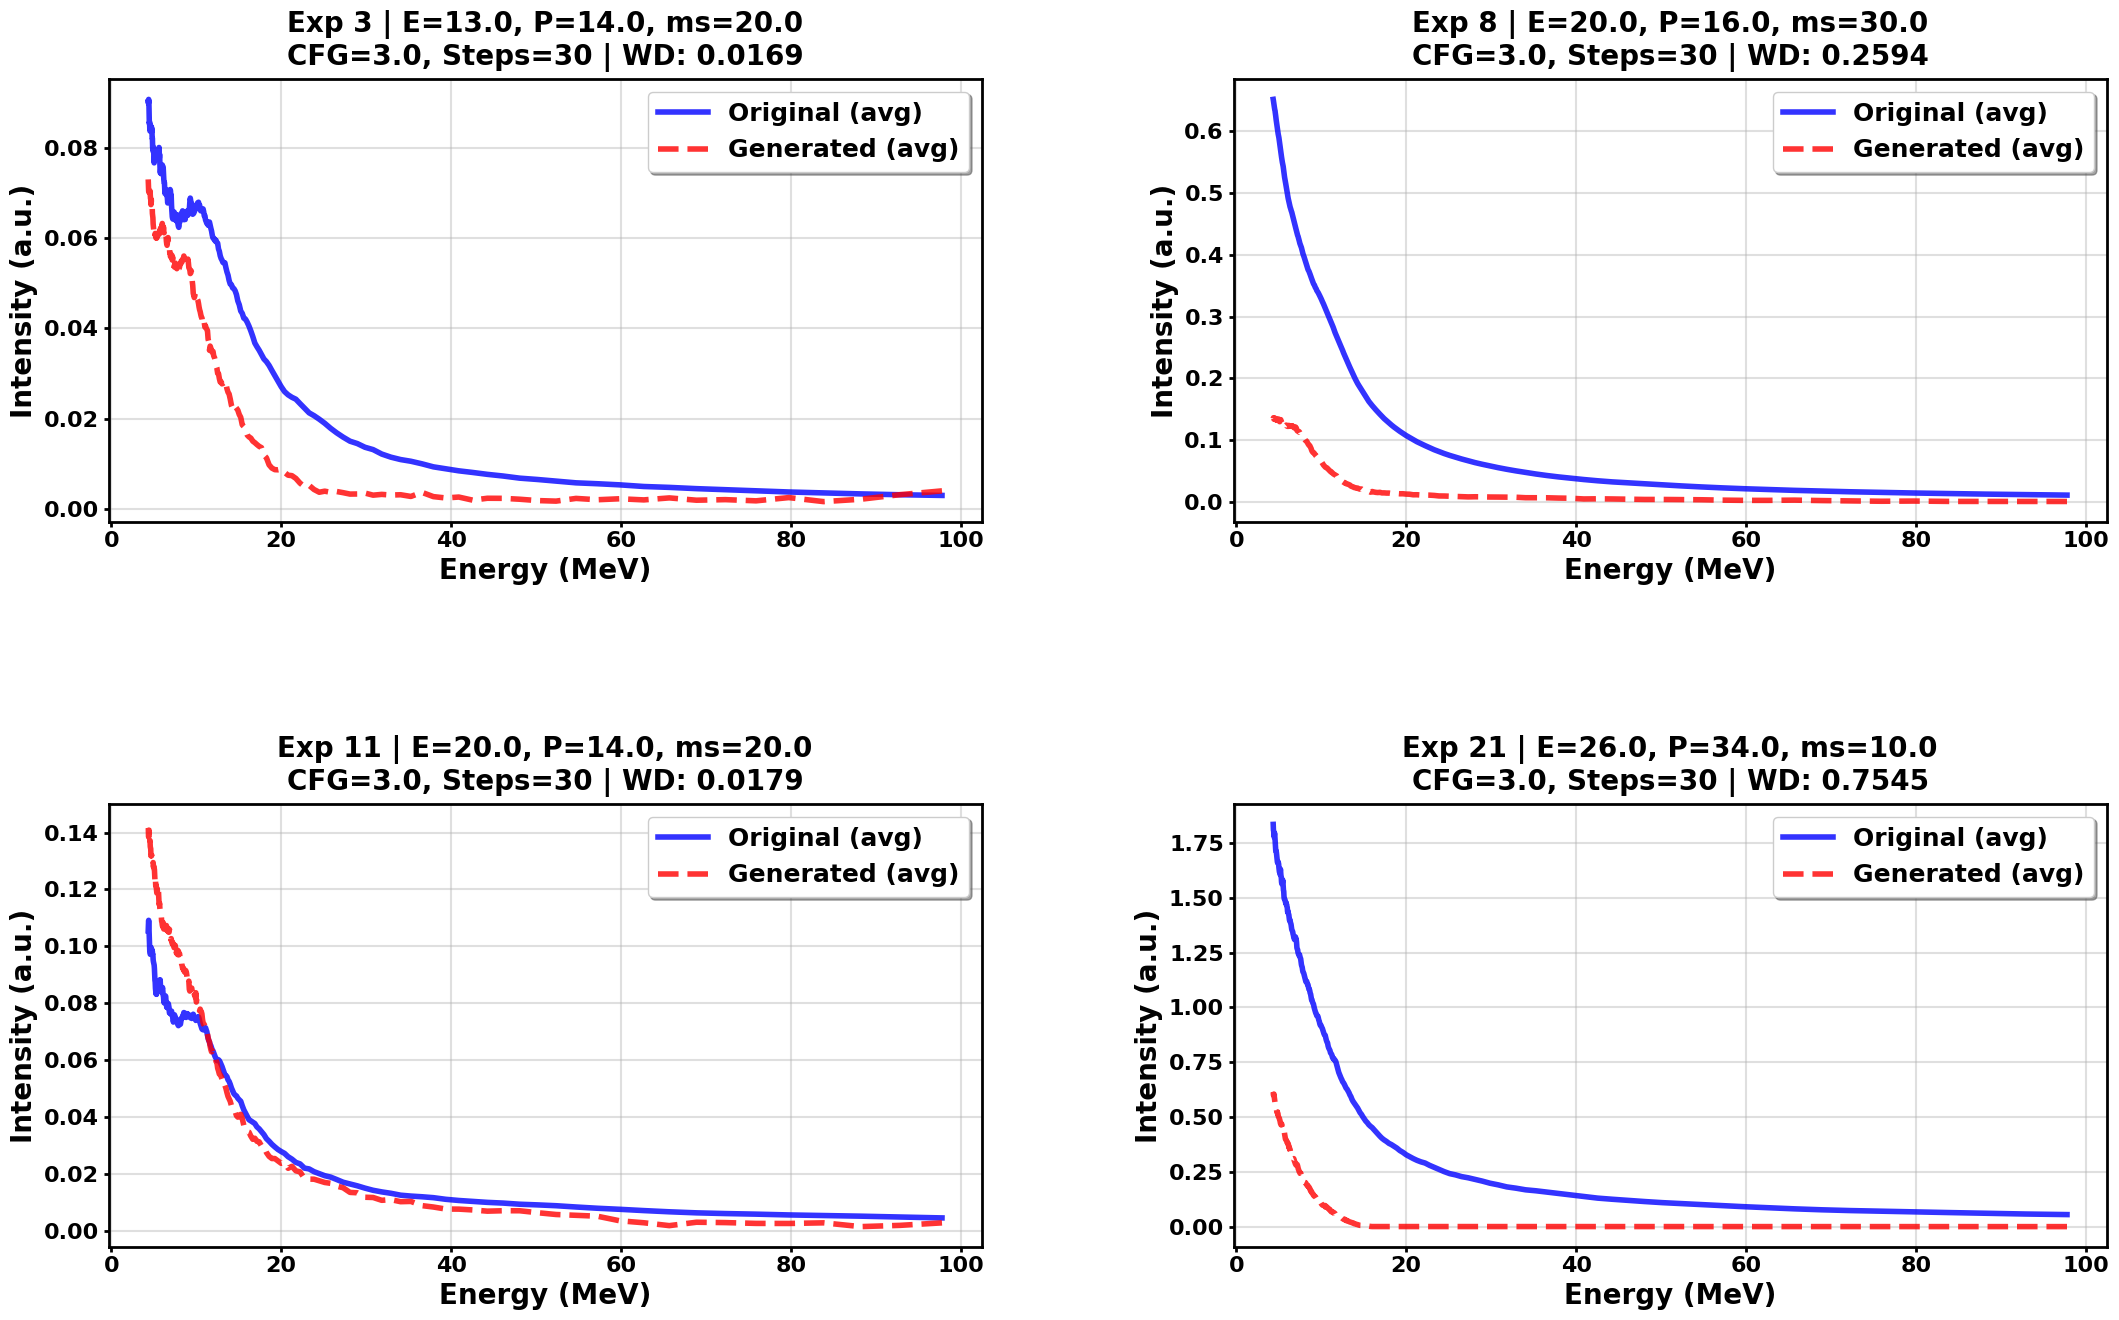


                          EVALUATION SUMMARY                          
CFG Scale: 3.0 | Sampling Steps: 30
Experiment      Wasserstein Distance      Status         
----------------------------------------------------------------------
3               0.016930                  ✓ Success      
8               0.259357                  ✓ Success      
11              0.017950                  ✓ Success      
21              0.754531                  ✓ Success      
----------------------------------------------------------------------
Average         0.262192                  ✓ Computed     
Std Dev         0.300921                  ✓ Computed     
Valid/Total     4/4                      ✓ Computed     


In [38]:
wasserstein_dist = evaluate_multiple_experiments(
    experiments=[3, 8, 11, 21],
    cfg_scale=3.0,
    num_steps=30
) 